In [423]:
import tensorflow as tf
import numpy as np
import math

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

In [424]:
# let's model y = 5 + x1*x2
def blackboxFn(X1, X2):
    return 6-X1*X2+X1**2+X2**2

def dataset(X1, X2, Y, start_index, N, D):
    X = np.zeros((N,D))
    y = np.zeros((N,1))
    X[:,0] = X1[start_index:start_index+N]
    X[:,1] = X2[start_index:start_index+N]
    y = Y[start_index:start_index+N].reshape(N, 1)
    return X,y

def mu_sigma(X):
    return np.mean(X, axis=0), np.std(X, axis=0)

def scale(X, mu, sigma):
    return (X-mu)/sigma

def blackboxFnScaled(X1, X2, mu, sigma):
    return scale(blackboxFn(X1, X2), mu, sigma)

def getReal(X, mu, sigma):
    return X*sigma+mu

In [425]:
N = 100
D = 2
X1 = 16*2*(np.random.rand(N)-0.5)
X2 = 16*2*(np.random.rand(N)-0.5)
Y = blackboxFn(X1, X2)

# 60% training, 20% cross-validation set and 20% test set
start_index = 0
training_N = int(N*0.6)
X_train_, y_train_ = dataset(X1, X2, Y, start_index, training_N, D)

start_index += training_N
cv_N = int(N*0.2)
X_val_, y_val_ = dataset(X1, X2, Y, start_index, cv_N, D)

start_index += cv_N
test_N = int(N*0.2)
X_test_, y_test_ = dataset(X1, X2, Y, start_index, test_N, D)

In [426]:
X_mu, X_sigma = mu_sigma(X_train_)
y_mu, y_sigma = mu_sigma(y_train_)
print("X_mu: ", X_mu)
print("X_sigma: ", X_sigma)
print("y_mu: ", y_mu)
print("y_sigma: ", y_sigma)

# scale
X_train = scale(X_train_, X_mu, X_sigma)
y_train = scale(y_train_, y_mu, y_sigma)

X_val = scale(X_val_, X_mu, X_sigma)
y_val = scale(y_val_, y_mu, y_sigma)

X_test = scale(X_test_, X_mu, X_sigma)
y_test = scale(y_test_, y_mu, y_sigma)

X_mu:  [ 3.4598753   1.57742161]
X_sigma:  [ 8.03309987  9.03217019]
y_mu:  [ 169.69421724]
y_sigma:  [ 124.27774273]


In [427]:
def show_3D_plot(X1, X2, Y, name, plot="surface"):
    %matplotlib notebook
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = None
    if plot == "scatter":
        surf = ax.scatter(X1, X2, Y)
    else:
        surf = ax.plot_surface(X1, X2, Y, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(name)
    plt.ion()
    plt.show()
    plt.savefig(name+'.png')

def surface_plot(X, name):
    X1_sorted = np.sort(X[:,0])
    X2_sorted = np.sort(X[:,1])
    X1,X2 = np.meshgrid(X1_sorted, X2_sorted)
    Y = blackboxFn(X1, X2)
    X1 = scale(X1, X_mu[0], X_sigma[0])
    X2 = scale(X2, X_mu[1], X_sigma[1])
    Y = scale(Y, y_mu[0], y_sigma[0])
    ind = np.argwhere(Y == np.min(Y))
    ix = ind[0,0]
    iy = ind[0,1]
    print("Optim X : ", X1[ix, iy], ",", X2[ix, iy])
    print("Y val: ", Y[ix, iy])
    print("Unscaled X val:", getReal(X1[ix, iy], X_mu[0], X_sigma[0]), ", ",getReal(X2[ix, iy], X_mu[1], X_sigma[1]))
    print("Unscaled Y val: ", getReal(Y[ix, iy], y_mu[0], y_sigma[0]))
    show_3D_plot(X1, X2, Y, name)

Optim X :  -0.426332335147 , -0.177304291982
Y val:  -1.31714304609
Unscaled X val: 0.0351050714519 ,  -0.0240209333734
Unscaled Y val:  6.00265262786


<IPython.core.display.Javascript object>


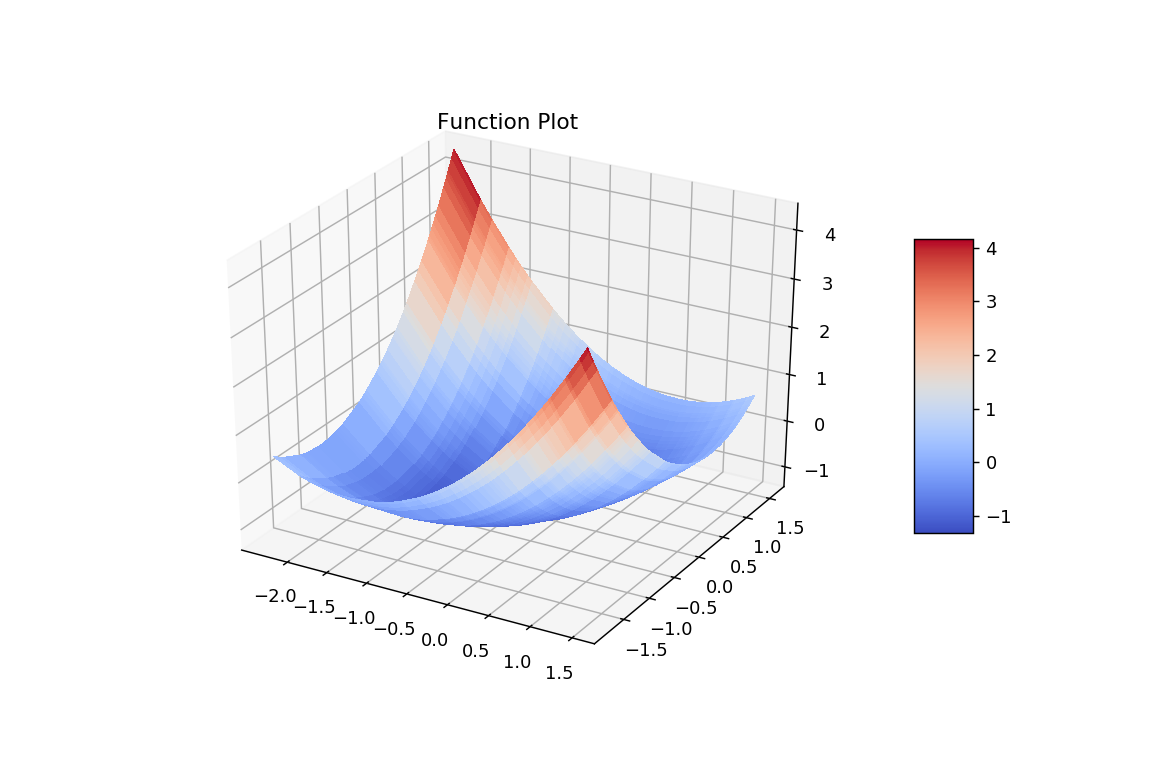

In [428]:
surface_plot(X_train_, "Function Plot")

<IPython.core.display.Javascript object>


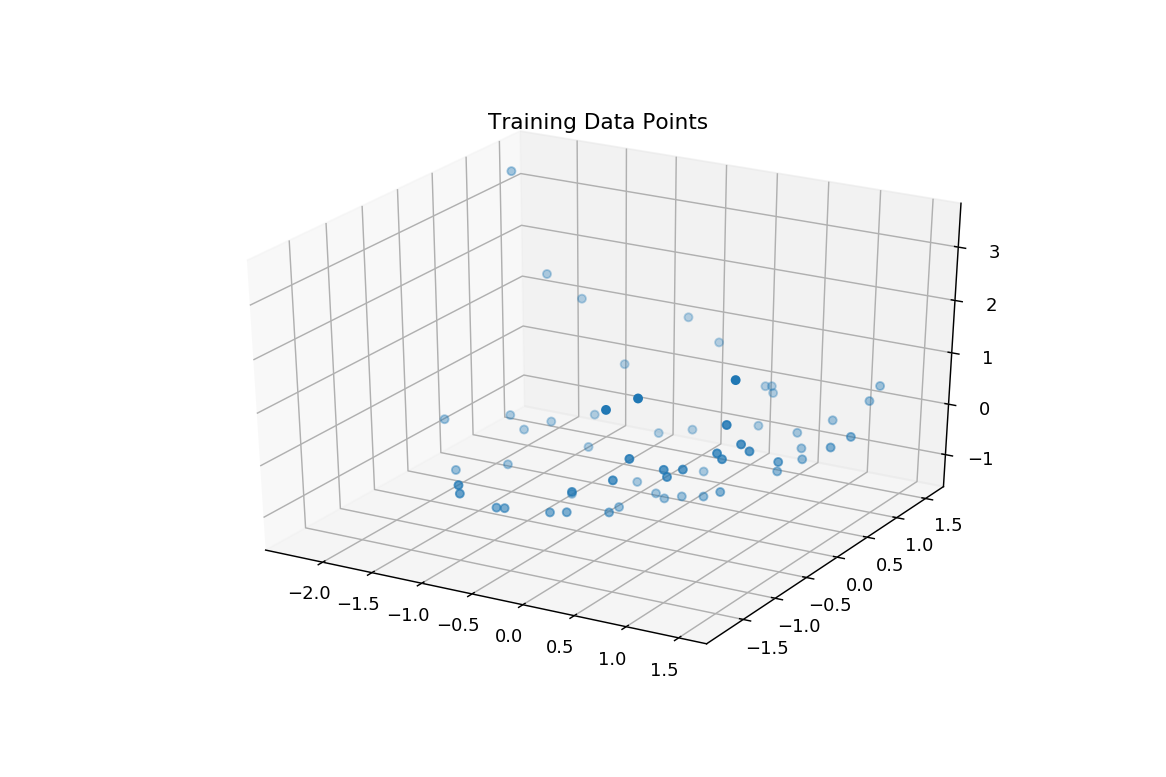

In [429]:
show_3D_plot(X_train[:,0], X_train[:,1], y_train, "Training Data Points", "scatter")

In [431]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

In [432]:
# clear old variables
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, D])
y = tf.placeholder(tf.float32, [None, 1])
is_training = tf.placeholder(tf.bool)

# Number of hidden neurons
H1 = 20
H2 = 20
def deeper_model(X):
    W1 = weight_variable([D,H1], "h1_weights")
    b1 = bias_variable([H1], "h1_biases")
    #W2 = weight_variable([H1,H2], "h2_weights")
    #b2 = bias_variable([H2], "h2_biases")
    W3 = weight_variable([H1,1], "out_weights")
    b3 = bias_variable([1], "out_biases")
    h1_out = tf.nn.tanh(tf.matmul(X, W1) + b1)
    #h2_out = tf.nn.tanh(tf.matmul(h1_out, W2) + b2)
    y_out = tf.matmul(h1_out, W3) + b3
    return y_out

y_out = deeper_model(X)

regularization_strength = 0.001
trainable_vars   = tf.trainable_variables()
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in trainable_vars if 'bias' not in v.name ])

mse_loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y, predictions=y_out))
#mse_loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y, predictions=y_out, weights=1/(y**2+1e-2)))
#mse_loss =  tf.reduce_mean(tf.losses.absolute_difference(labels=y, predictions=y_out))
mean_loss = mse_loss + lossL2*regularization_strength

In [433]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot=False):
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    
    variables = [mean_loss, mse_loss, predict]
    if training_now:
        variables[-1] = training
        
    training_epoch_loss = []
    training_epoch_ms_loss = []
    validation_epoch_loss = []
    validation_epoch_ms_loss = []
    total_loss = 0
    total_mean_squared_loss = 0
    for e in range(epochs):
        # keep track of losses and ms losses
        losses = []
        squared_losses = []
        
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, squared_loss, _ = session.run(variables,feed_dict=feed_dict)
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            squared_losses.append(squared_loss*actual_batch_size)
        
        total_loss = np.sum(losses)/Xd.shape[0]
        total_mean_squared_loss = np.sum(squared_losses)/Xd.shape[0]
        
        # print every now and then
        if print_every and ((e % print_every) == 0 or e == epochs-1):
            print("Epoch {2}, Overall loss = {0:.3g} and MSE loss of {1:.3g}"\
                  .format(total_loss,total_mean_squared_loss,e+1))
        
        if training_now:
            training_epoch_loss.append(total_loss)
            training_epoch_ms_loss.append(total_mean_squared_loss)
            cv_loss, cv_ms_loss = run_model(session,predict,loss_val,X_val,y_val,1,batch_size,None)
            validation_epoch_loss.append(cv_loss)
            validation_epoch_ms_loss.append(cv_ms_loss)
        
    if plot:
        plt.plot(training_epoch_loss)
        plt.plot(validation_epoch_loss)
        plt.plot(training_epoch_ms_loss)
        plt.plot(validation_epoch_ms_loss)
        plt.grid(True)
        plt.title('Training vs Cross-Validation')
        plt.xlabel('epoch number')
        plt.ylabel('loss')
        plt.legend(['Training Loss','Cross-Validation Loss', 'Training MSE Loss', 'Cross-Validation MSE Loss'], loc='upper left')
        plt.show()
        
    return total_loss, total_mean_squared_loss



Training
Epoch 1, Overall loss = 1.03 and MSE loss of 1.03
Epoch 101, Overall loss = 0.0181 and MSE loss of 0.00566
Epoch 201, Overall loss = 0.0139 and MSE loss of 0.00193
Epoch 301, Overall loss = 0.0134 and MSE loss of 0.00211
Epoch 401, Overall loss = 0.0139 and MSE loss of 0.00321
Epoch 501, Overall loss = 0.0114 and MSE loss of 0.00113
Epoch 601, Overall loss = 0.0113 and MSE loss of 0.00154
Epoch 701, Overall loss = 0.0107 and MSE loss of 0.00109
Epoch 801, Overall loss = 0.0106 and MSE loss of 0.00115
Epoch 901, Overall loss = 0.0104 and MSE loss of 0.00113
Epoch 1001, Overall loss = 0.0102 and MSE loss of 0.000994
Epoch 1101, Overall loss = 0.0105 and MSE loss of 0.0014
Epoch 1201, Overall loss = 0.0101 and MSE loss of 0.00106
Epoch 1301, Overall loss = 0.00989 and MSE loss of 0.000931
Epoch 1401, Overall loss = 0.00976 and MSE loss of 0.000857
Epoch 1501, Overall loss = 0.00996 and MSE loss of 0.00112
Epoch 1601, Overall loss = 0.00974 and MSE loss of 0.000934
Epoch 1701, Ove

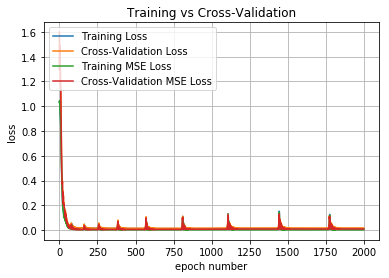

Test
Epoch 1, Overall loss = 0.0255 and MSE loss of 0.0169


In [434]:
%matplotlib inline
train_step = tf.train.AdamOptimizer(0.1).minimize(mean_loss)
sess = tf.Session()
with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess,y_out,mean_loss,X_train,y_train,2000,64,100,train_step, plot=True)
    print('Test')
    run_model(sess,y_out,mean_loss,X_test,y_test,1,16, plot=False)

In [435]:
def y_predict(X_, session):
    return session.run(y_out, {X: X_})

def nn_surface_plot(X, session, name):
    X1_sorted = np.sort(X[:,0])
    X2_sorted = np.sort(X[:,1])
    X1,X2 = np.meshgrid(X1_sorted, X2_sorted)
    M, _ = np.shape(X1)
    X_mesh = np.zeros((M*M, 2))
    X_mesh[:,0] = np.reshape(X1, (-1))
    X_mesh[:,1] = np.reshape(X2, (-1))
    Y = y_predict(X_mesh, session).reshape((M,M))
    ind = np.argwhere(Y == np.min(Y))
    ix = ind[0,0]
    iy = ind[0,1]
    print("Optim X : ", X1[ix, iy], ",", X2[ix, iy])
    print("Y val: ", Y[ix, iy])
    X1_ = getReal(X1[ix, iy], X_mu[0], X_sigma[0])
    X2_ = getReal(X2[ix, iy], X_mu[1], X_sigma[1])
    print("Unscaled X val:", X1_, ", ", X2_)
    print("Unscaled Y val: ", getRealY(Y[ix, iy], y_mu[0], y_sigma[0]))
    print("Actual Y val: ", blackboxFn(X1_, X2_))
    show_3D_plot(X1, X2, Y, name)

Optim X :  -0.368476653753 , -0.170211397081
Y val:  -1.31530200744
Unscaled X val: 0.499865538009 ,  0.0400433005034
Unscaled Y val:  6.23145275605


<IPython.core.display.Javascript object>


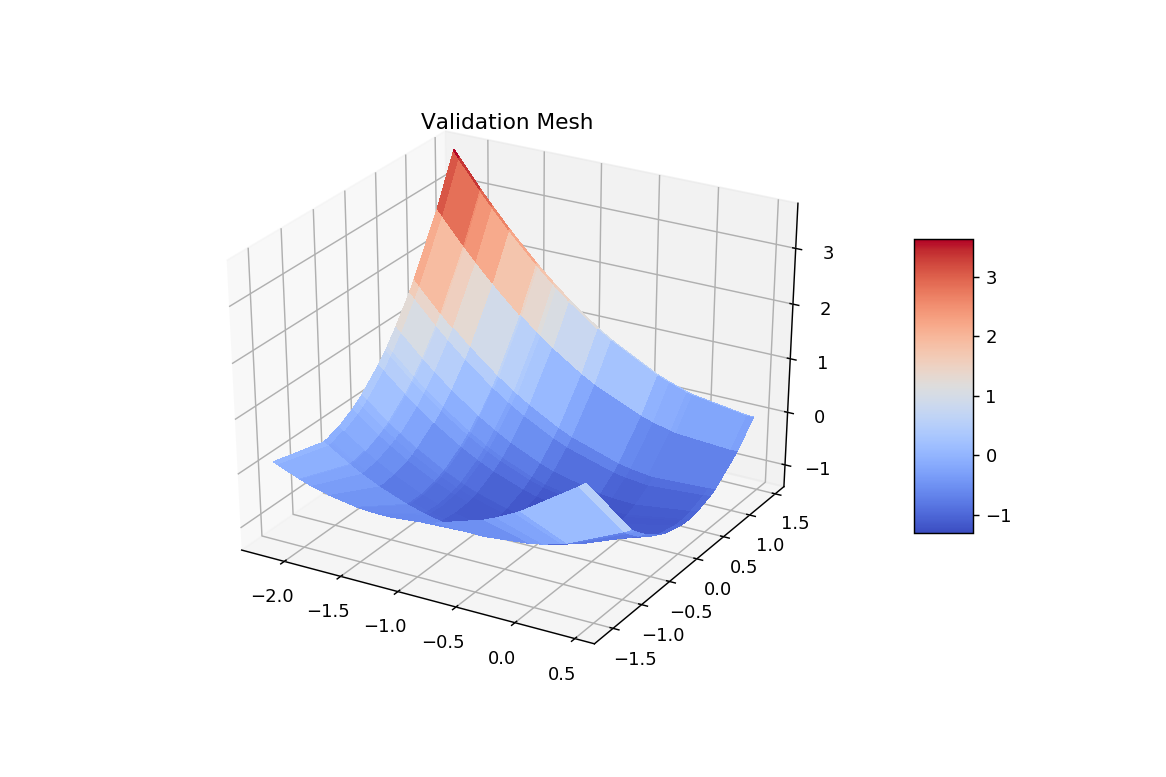

In [437]:
surface_plot(X_val_, "Validation Mesh")

Optim X :  -0.368476653753 , -0.170211397081
Y val:  -1.2632
Unscaled X val: 0.499865538009 ,  0.0400433005034
Unscaled Y val:  12.7061818934
Actual Y val:  6.23145275605


<IPython.core.display.Javascript object>


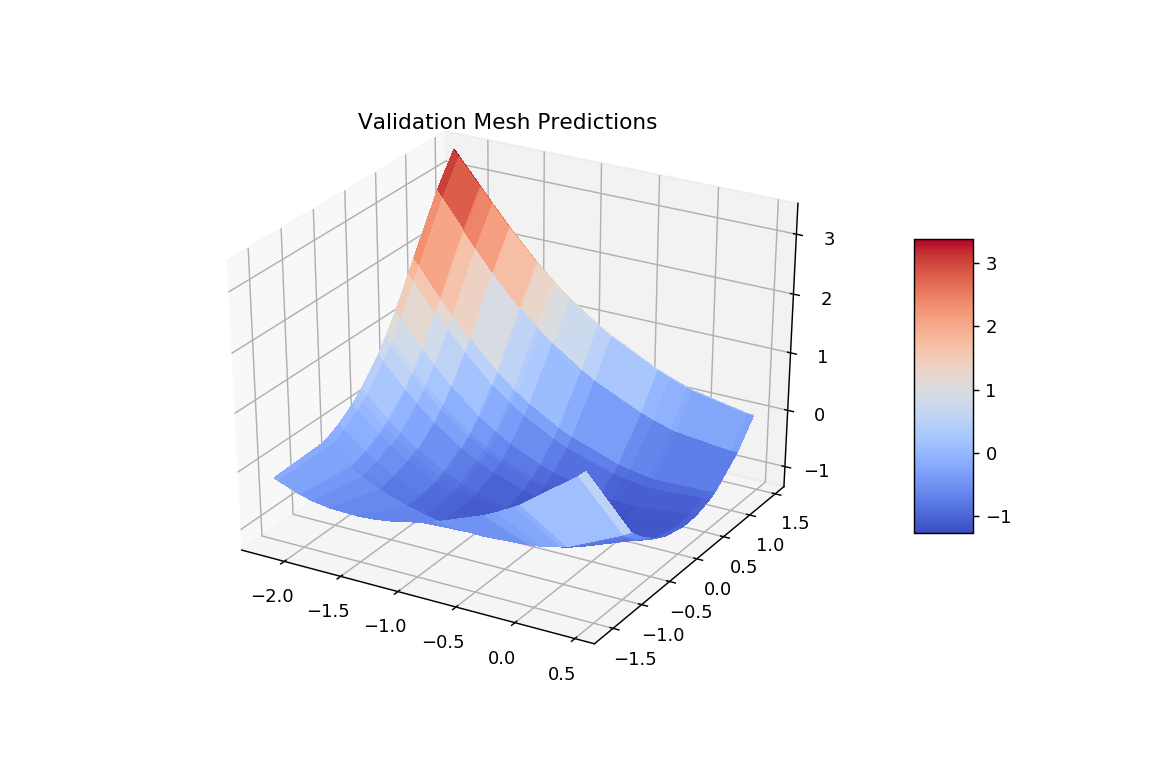

In [438]:
nn_surface_plot(X_val, sess, "Validation Mesh Predictions")

In [439]:
def getX(X_i, target_y, num_iters=100, learning_rate=0.1, print_every=10):
    targetXs = []
    realTargetXs = []
    realTargetYs = []
    target_X = X_i.copy()
    grads = tf.gradients(mean_loss, X)
    y_val = 0
    for i in range(num_iters+1):
        targetXs.append(target_X.copy())
        y_val = y_predict(target_X, sess)
        if abs(y_val - target_y) < 1e-3:
            print("Iteration ", i)
            break
        g = sess.run(grads, {X: target_X, y: np.array([[target_y]])})
        dX = learning_rate * g[0] / tf.norm(g[0])
        dX_val = -1 * dX.eval(session=sess)
        
        real_target_X = getReal(target_X, X_mu, X_sigma)
        real_target_Y = getReal(y_val, y_mu, y_sigma)
        realTargetXs.append(real_target_X)
        realTargetYs.append(real_target_Y)
        if print_every and i % print_every == 0:
            print("Iteration: ", i)
            print("y_val of ", target_X, " is ", y_val)
            print("Unscaled y_val of Unscaled ", real_target_X, " is ", real_target_Y)
        if i < num_iters:
            target_X += dX_val
    return target_X, realTargetXs, realTargetYs

In [440]:
def getOptimalX(X, target_y, can_print=False):
    y_scaled = scale(target_y, y_mu[0], y_sigma[0])
    X_scaled = scale(X, X_mu, X_sigma)
    print_every = None
    if can_print:
        print(X_scaled)
        print(y_scaled)
        print_every = 20

    optim_X, realTargetXs, realTargetYs = getX(X_scaled, y_scaled, 200, 0.01, print_every)
    optim_X_unscaled = getReal(optim_X, X_mu, X_sigma)
    actual_y = blackboxFn(optim_X_unscaled[:,0], optim_X_unscaled[:,1])
    if can_print:
        print("Actual y_val of optim_X is ", actual_y)
    return optim_X_unscaled, actual_y, realTargetXs, realTargetYs
    
X_i = np.array([[10.0,5.0]])
target_y = 0.0
optim_X_unscaled, actual_y, realTargetXs, realTargetYs = getOptimalX(X_i, target_y, True)

[[ 0.81414707  0.37893201]]
-1.36544334907
Iteration:  0
y_val of  [[ 0.81414707  0.37893201]]  is  [[-0.70886445]]
Unscaled y_val of Unscaled  [[ 10.   5.]]  is  [[ 81.59814344]]
Iteration:  20
y_val of  [[ 0.6143294   0.37381798]]  is  [[-0.89830112]]
Unscaled y_val of Unscaled  [[ 8.3948447   4.95380918]]  is  [[ 58.05538119]]
Iteration:  40
y_val of  [[ 0.41717874  0.34141468]]  is  [[-1.03998971]]
Unscaled y_val of Unscaled  [[ 6.8111138   4.66113706]]  is  [[ 40.44664364]]
Iteration:  60
y_val of  [[ 0.2284963   0.27591802]]  is  [[-1.13984871]]
Unscaled y_val of Unscaled  [[ 5.29540886  4.06956016]]  is  [[ 28.03639263]]
Iteration:  80
y_val of  [[ 0.05392181  0.17876129]]  is  [[-1.20671797]]
Unscaled y_val of Unscaled  [[ 3.89303457  3.19202402]]  is  [[ 19.72603207]]
Iteration:  100
y_val of  [[-0.10671292  0.05974516]]  is  [[-1.24699116]]
Unscaled y_val of Unscaled  [[ 2.60263977  2.1170501 ]]  is  [[ 14.72097099]]
Iteration:  120
y_val of  [[-0.26013873 -0.06854733]]  is  

<IPython.core.display.Javascript object>


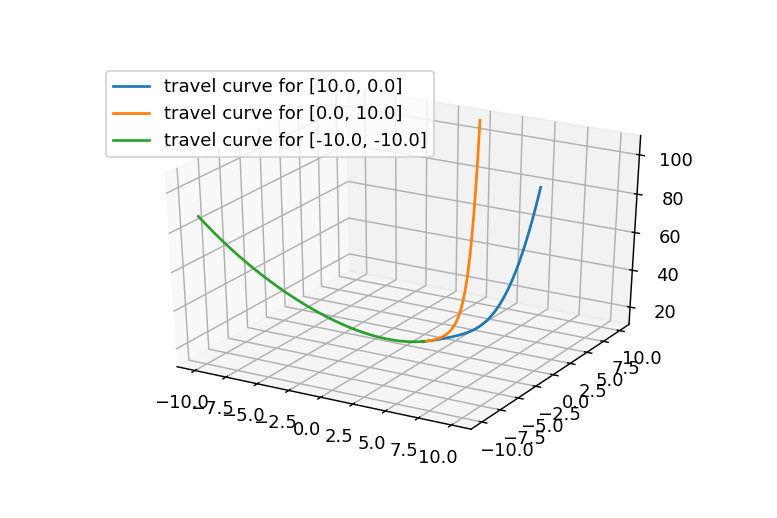

Started:  [10.0, 0.0]
Done.
Started:  [0.0, 10.0]
Done.
Started:  [-10.0, -10.0]
Done.


In [441]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X_L = [[10.0,0.0],[0.0,10.0],[-10.0,-10.0]] 
for Xi in X_L:
    print("Started: ", Xi)
    X_i = np.array([Xi])
    target_y = 0
    optim_X_unscaled, actual_y, realTargetXs, realTargetYs = getOptimalX(X_i, target_y, False)
    print("Done.")
    pz = np.array(realTargetYs)[:,0,0]
    px = np.array(realTargetXs)[:,0,0]
    py = np.array(realTargetXs)[:,0,1]
    ax.plot(px, py, pz, label='travel curve for ' + str(Xi))
ax.legend()
plt.show()